Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


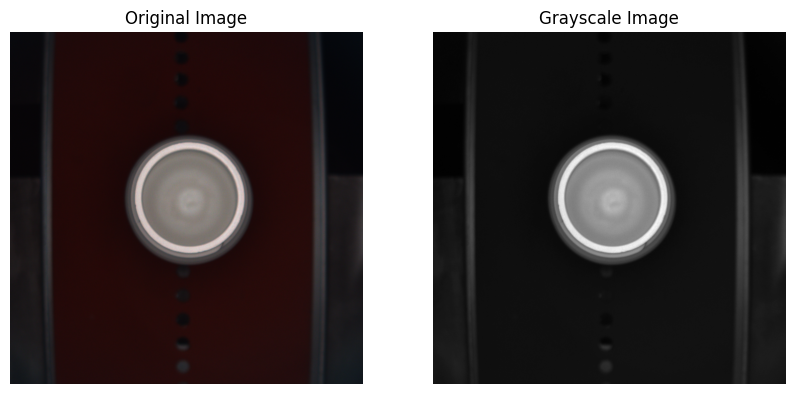

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/drive/MyDrive/dataset/30ML_BOTTLE/topview/original_images/Line1Cam3PassImage811_1636_35127.png"  # Replace with your image path
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Show original and grayscale images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grayscale Image")
plt.imshow(gray_image, cmap="gray")
plt.axis("off")

plt.show()



# Dataset Ehancement

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

class DefectDetectionPipeline:
    """
    Combined pipeline for object detection and multi-scale enhancement
    """

    def __init__(self, input_folder, output_folder):
        self.input_folder = input_folder
        self.output_folder = output_folder

        # Create output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

    def enhance_dark_spots_multiscale(self, image):
        """
        Multi-scale enhancement specifically for surface defects
        Uses different Gaussian blur scales to highlight defects at various sizes
        """
        # Convert to grayscale for processing
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image

        # Apply different scales of Gaussian blur and subtract
        scales = [3, 7, 15, 31]  # Different blur kernel sizes
        enhanced = gray.astype(np.float32)

        # For each scale, subtract the blurred version to highlight details
        for scale in scales:
            blurred = cv2.GaussianBlur(gray, (scale, scale), 0).astype(np.float32)
            diff = gray.astype(np.float32) - blurred
            enhanced += diff * 0.5  # Add weighted difference

        # Normalize and clip values
        enhanced = np.clip(enhanced, 0, 255)
        enhanced = enhanced.astype(np.uint8)

        # Apply adaptive histogram equalization for final contrast enhancement
        enhanced = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16)).apply(enhanced)

        return enhanced

    def detect_and_extract_object(self, img):
        """
        Simple object detection
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Threshold (adjust value depending on dataset)
        _, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)


        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            return None, None

        # Assume largest contour is the object
        c = max(contours, key=cv2.contourArea)

        # Create empty mask and draw contour
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [c], -1, 255, -1)

        # Extract object
        object_only = cv2.bitwise_and(img, img, mask=mask)

        return object_only, mask

    def process_single_image(self, img_path, show_results=False, save_detected=False):
        """
        Process a single image through the complete pipeline
        Detection -> Enhancement -> Save final result
        """
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping {img_path}, could not load.")
            return None

        filename = os.path.basename(img_path)

        # Step 1: Object Detection and Extraction (exactly like original)
        object_only, mask = self.detect_and_extract_object(img)

        if object_only is None:
            print(f"No object detected in {img_path}")
            return None

        # Step 2: Apply Multi-scale Enhancement to detected object
        # Convert BGR to RGB for enhancement
        object_rgb = cv2.cvtColor(object_only, cv2.COLOR_BGR2RGB)
        enhanced = self.enhance_dark_spots_multiscale(object_rgb)

        # Convert back to BGR and apply to color image
        enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

        # Apply enhancement only to the object area using the mask
        enhanced_result = np.zeros_like(object_only)
        enhanced_result[mask > 0] = enhanced_bgr[mask > 0]

        # Save final enhanced result
        enhanced_filename = f"enhanced_{filename}"
        enhanced_save_path = os.path.join(self.output_folder, enhanced_filename)
        cv2.imwrite(enhanced_save_path, enhanced_result)

        print(f"Saved enhanced image to {enhanced_save_path}")

        # Optionally save detected object (for debugging/comparison)
        if save_detected:
            detected_filename = f"detected_{filename}"
            detected_save_path = os.path.join(self.output_folder, detected_filename)
            cv2.imwrite(detected_save_path, object_only)
            print(f"Saved detected object to {detected_save_path}")

        # Display results if requested
        if show_results:
            self.display_results(img, object_only, enhanced_result, filename)

        return {
            'original': img,
            'detected': object_only,
            'enhanced': enhanced_result,
            'mask': mask
        }

    def display_results(self, original, detected, enhanced, filename):
        """
        Display the processing results
        """
        num_plots = 3 if enhanced is not None else 2
        plt.figure(figsize=(5 * num_plots, 4))

        # Original image
        plt.subplot(1, num_plots, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image', fontsize=12, fontweight='bold')
        plt.axis('off')

        # Detected object
        plt.subplot(1, num_plots, 2)
        plt.imshow(cv2.cvtColor(detected, cv2.COLOR_BGR2RGB))
        plt.title('Detected Object', fontsize=12, fontweight='bold')
        plt.axis('off')

        # Enhanced result (if available)
        if enhanced is not None:
            plt.subplot(1, num_plots, 3)
            plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
            plt.title('Enhanced Defects', fontsize=12, fontweight='bold')
            plt.axis('off')

        plt.suptitle(f'Processing Results: {filename}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def process_batch(self, show_results=False, save_detected=False):
        """
        Process all PNG images in the input folder through the pipeline:
        Detection -> Enhancement -> Save final results only
        """
        # Get all PNG images in folder
        image_files = glob.glob(os.path.join(self.input_folder, "*.png"))

        print(f"Found {len(image_files)} images")

        for img_path in image_files:
            self.process_single_image(
                img_path,
                show_results=show_results,
                save_detected=save_detected
            )

# Example usage
if __name__ == "__main__":
    # Configuration
    input_folder = "/content/drive/MyDrive/dataset/50ML_bottles/topview/original_images"
    output_folder = "/content/drive/MyDrive/dataset/50ML_bottles/topview/good"

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Create pipeline instance
    pipeline = DefectDetectionPipeline(
        input_folder=input_folder,
        output_folder=output_folder
    )

    # Process all images: Detection → Enhancement → Save final results
    pipeline.process_batch()

    # Alternative: Process a single image with visualization
    # single_image_path = "/path/to/your/image.png"
    # result = pipeline.process_single_image(single_image_path, show_results=True)

Found 50 images
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam4PassImage812_834_39316.png
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam3PassImage812_835_1452.png
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam4PassImage812_835_51936.png
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam4PassImage812_835_1452.png
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam4PassImage812_834_1308.png
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam3PassImage812_835_51936.png
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam4PassImage812_835_30403.png
Saved enhanced image to /content/drive/MyDrive/dataset/50ML_bottles/topview/good/enhanced_Line1Cam3PassIm